# Notebook configuration

In [1]:
filename_pattern = "$IC_DATA/MC/Kr/*.h5"
n_events_plot    = 10
n_events_stat    = float("inf")

# Graphics
figure_size      = 12, 8
font_size        = 20

# Imports

In [2]:
import os
import sys
import glob
import time

import numpy             as np
import matplotlib.pyplot as plt

import invisible_cities.database.load_db       as DB
import invisible_cities.io      .pmap_io       as pmpio
import invisible_cities.io      .mchits_io     as mchio
import invisible_cities.core    .fit_functions as fitf
import invisible_cities.core    .exceptions    as excpt
import invisible_cities.reco    .xy_algorithms as XY

from invisible_cities.icaro.hst_functions import hist
from invisible_cities.icaro.hst_functions import hist2d
from invisible_cities.icaro.hst_functions import labels
from invisible_cities.icaro.hst_functions import measurement_string

# Graphics configuration

In [3]:
%matplotlib inline

plt.rcParams["figure.figsize"] = figure_size
plt.rcParams[  "font.size"   ] =   font_size

# Functions definition

In [4]:
def barycenter_Si(si, **corona_opts):
    IDs, Qs = zip(*si.sipm_total_energy_dict(0).items())
    return XY.corona(xy_sipm[list(IDs)], np.array(Qs), lm_radius=-1, **corona_opts)[0]

def barycenter_MC(hits):
    pos, Qs = zip(*[((hit.X, hit.Y), hit.E) for hit in hits])
    return XY.corona(np.array(pos), np.array(Qs), lm_radius=-1)[0]

def get(array, attr):
    return np.array([getattr(x, attr) for x in array])

def plot_si(si, Qthr=0):
    IDs, Qs = map(np.array, zip(*si.sipm_total_energy_dict(0).items()))
    Xs , Ys = xy_sipm[IDs].T

    s = plt.scatter(Xs, Ys, c=Qs, marker="s")
    b = barycenter_Si(si, Qthr=Qthr)

    IDs_below_threshold = IDs[Qs < Qthr]
    if IDs_below_threshold.size:
        Xs_below_threshold,\
        Ys_below_threshold = xy_sipm[IDs_below_threshold].T

        plt.scatter(Xs_below_threshold,
                    Ys_below_threshold,
                    marker    = "o",
                    s         = 500,
                    edgecolor = "y",
                    facecolor = "none")
    plt.scatter(b.X, b.Y, marker="x", c="r")
    return plt.colorbar(s)

def plot_mc(hits):
    Xs, Ys, Qs = zip(*[(hit.X, hit.Y, hit.E) for hit in hits])
    plt.scatter(Xs, Ys, c="k", marker="*")

# Initialization

In [5]:
DataSiPM = DB.DataSiPM()
xy_sipm  = np.stack([DataSiPM.X.values,
                     DataSiPM.Y.values], axis=1)

In [6]:
def print_progress_bar(i, total, n_max=20, symbol="·"):
    percent  = i / total
    progress = int(np.ceil(percent * n_max))

    progress_bar_string = (symbol * progress + ">").ljust(n_max + 1)
    percent_string      = str(int(percent*100)).zfill(3)
    print("\r[{0}] {1}%".format(progress_bar_string, percent_string), end="", flush=True)

In [7]:
filenames = glob.glob(os.path.expandvars(filename_pattern))[:2]
S1, S2, Si, MChits = {}, {}, {}, {}
for i, filename in enumerate(filenames, start=1):
    print_progress_bar(i, len(filenames))
    s1, s2, si = pmpio.load_pmaps(filename)
    S1.update(s1)
    S2.update(s2)
    Si.update(si)
    
    try:
        mchits = mchio.load_mchits(filename)
        MChits.update(mchits)
    except:
        pass

    evts = set(si)
    if len(evts) > max(n_events_plot, n_events_stat):
        break

[····················>] 100%

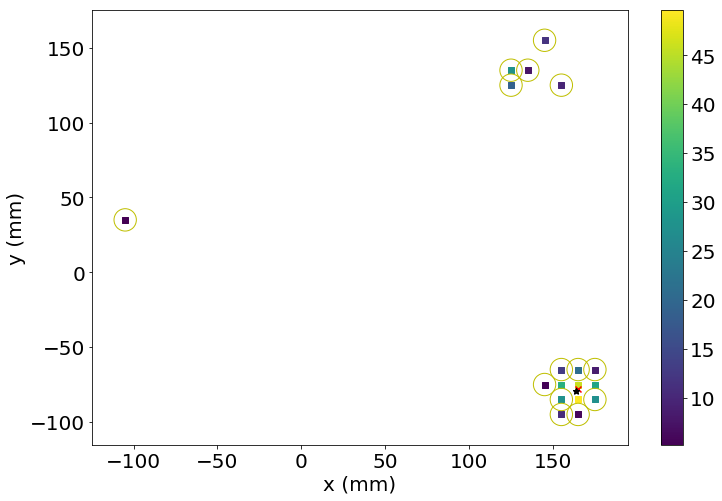

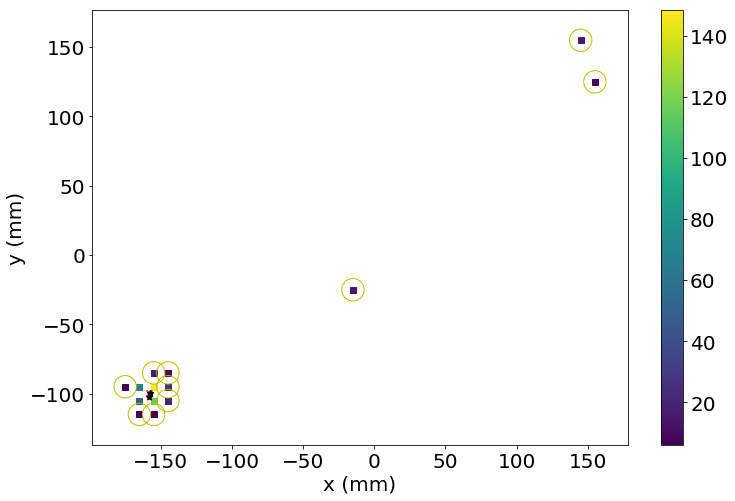

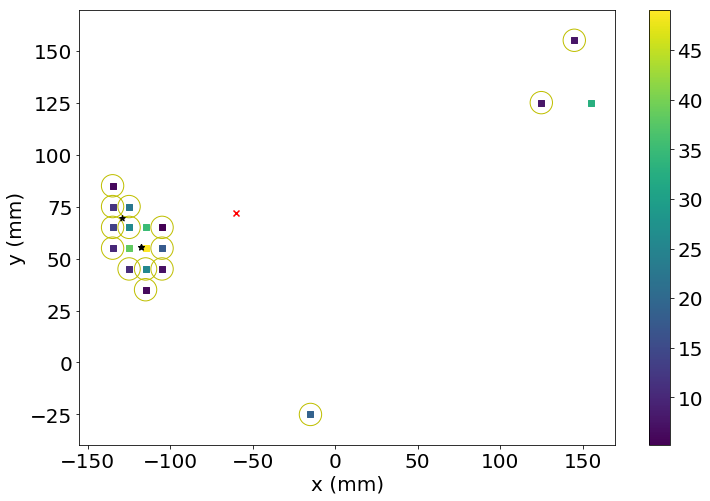

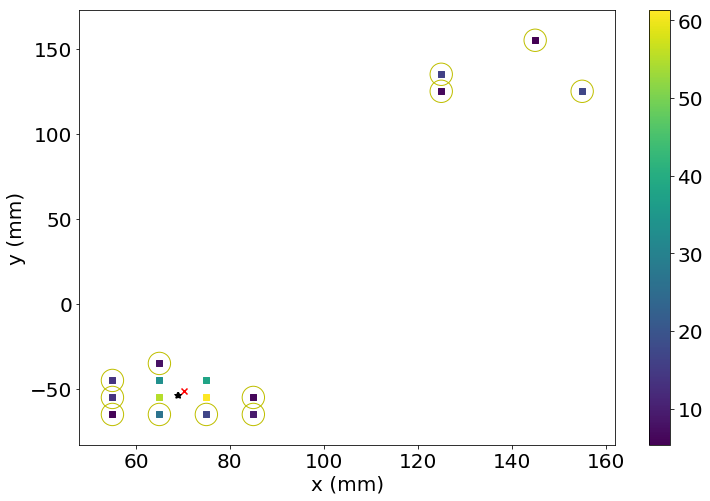

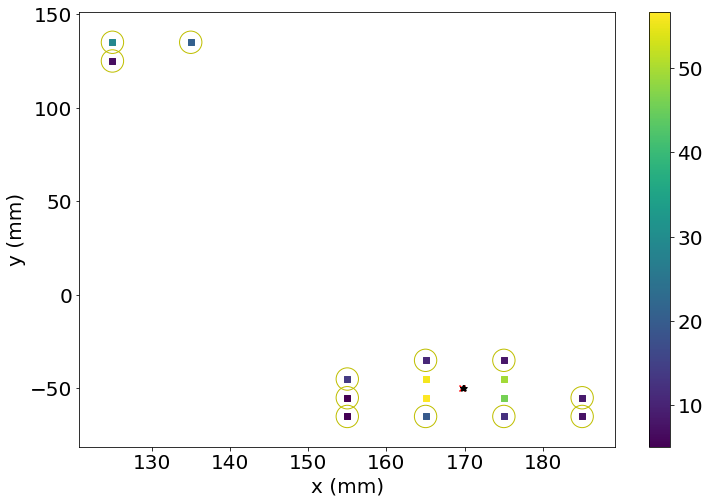

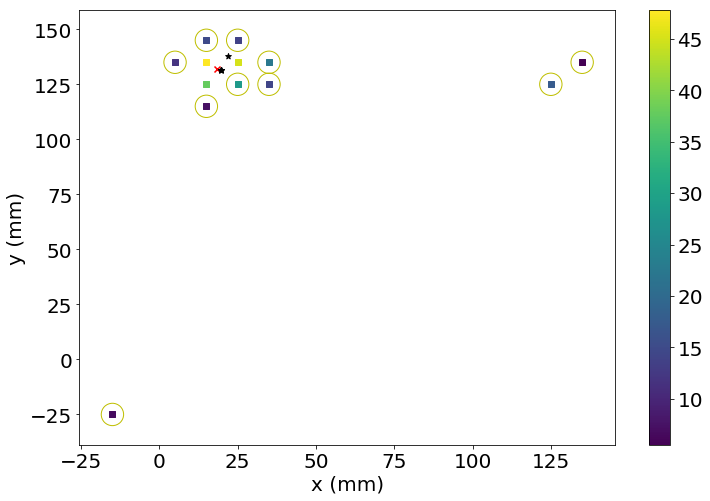

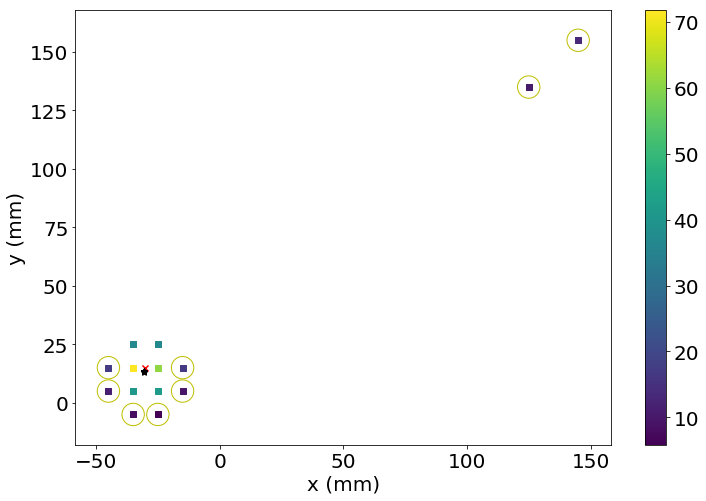

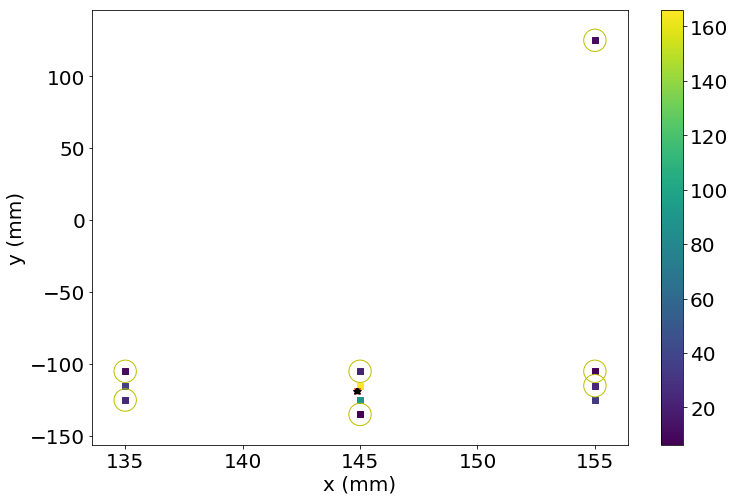

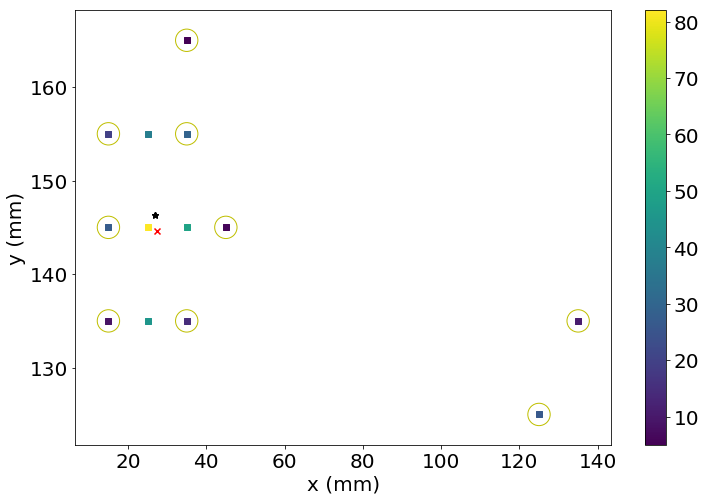

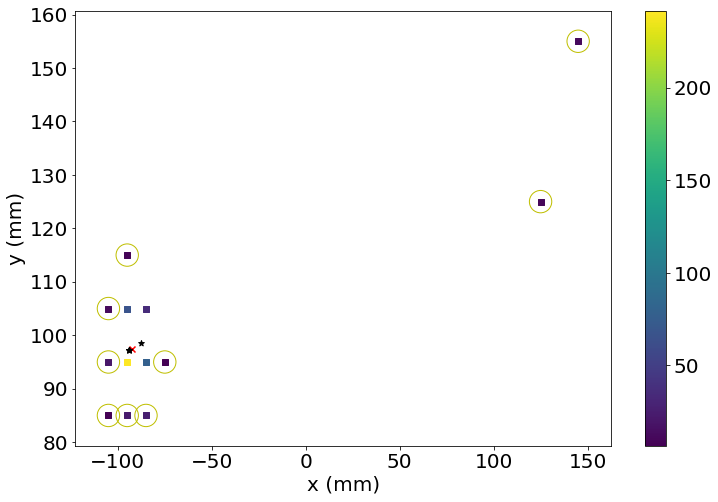

In [12]:
for evt in sorted(evts)[:n_events_plot]:
    plt.figure()
    plot_si(Si[evt], 30)
    if len(MChits):
        plot_mc(MChits[evt])
    labels("x (mm)", "y (mm)")